# Download dataset from Kaggle

In [ ]:
import os
import shutil

def remove_dataset_folder(folder_name):
    folder_path = os.path.join('datasets', folder_name)
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        print(f"Removing old folder: {folder_path}")
        shutil.rmtree(folder_path)
    else:
        print(f"No existing folder to remove at: {folder_path}")

# Example usage: delete "rice_leaf" folder inside ./datasets
remove_dataset_folder('./dataset/Nutrient Deficient Banana Plant Leaves')

In [28]:
import kagglehub

path = kagglehub.dataset_download("guy007/nutrientdeficiencysymptomsinrice")

print("Path to dataset files:", path)
# C:\Users\jpark\.cache\kagglehub\datasets\warcoder\nutrient-deficient-banana-plant-leaves\versions\1

100%|██████████| 989M/989M [01:49<00:00, 9.46MB/s] 

Extracting files...


Path to dataset files: C:\Users\jpark\.cache\kagglehub\datasets\guy007\nutrientdeficiencysymptomsinrice\versions\1


# Move the dataset from local machine's cache to the root folder

In [30]:
def clean_dataset_folder(target_path):
    if os.path.exists(target_path):
        shutil.rmtree(target_path)
    os.makedirs(target_path, exist_ok=True)

def copy_from_kagglehub(src, dest):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dest, item)
        if os.path.isdir(s):
            shutil.copytree(s, d)
        else:
            shutil.copy2(s, d)

# Step 2: Clean target dataset folder
target_folder = os.path.join(".", "dataset", "nutrientdeficiencysymptomsinrice")
clean_dataset_folder(target_folder)

# Step 3: Copy files from kagglehub cache to target dataset folder
copy_from_kagglehub(path, target_folder)

print("✅ Dataset ready at:", target_folder)

✅ Dataset ready at: .\dataset\nutrientdeficiencysymptomsinrice


# Process images (Resize and Augment)

In [32]:
# PROCESSING IMAGES
  # resizing: for uniform image sizes (set to 640x640)
  # augmentation: for balancing of training dataset

import cv2
import os
import numpy as np
import albumentations as A
import random
import tensorflow as tf

dataset_path = "./dataset/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients"

# Target image size
TARGET_SIZE = (224, 224)

# Maximum images per class
MAX_IMAGES_PER_CLASS = 1000

# Sequential augmentation functions 
transform = A.Compose([
    A.Rotate(limit=20), # Randomly rotates the image between -20 and +20 degrees
    A.HorizontalFlip(p=0.5), # probability of it happening (0.5: 50% chance of applying)
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
])

# Function to resize (224) and augment images 
def process_images(path):
    for class_folder in os.listdir(path):
        class_path = os.path.join(path, class_folder)

        # Get list of images
        img_files = os.listdir(class_path)
        original_count = len(img_files)

        # Resize and convert images
        for img_name in img_files:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Couldn't read {img_path}")
                continue

            img_resized = cv2.resize(img, TARGET_SIZE)
            cv2.imwrite(img_path, img_resized)

        # Calculate how many more images are needed
        needed_augmentations = max(0, MAX_IMAGES_PER_CLASS - original_count)

        # Generate only the required number of augmented images
        for i in range(needed_augmentations):
            img_name = random.choice(img_files)  # Pick a random image
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            # transform image to make augmented images
            # ['image'] used because transform returns dictionary and we only want the image
            augmented = transform(image=img)['image']
            aug_img_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
            cv2.imwrite(os.path.join(class_path, aug_img_name), augmented)

        print(f"{class_folder} processing complete now with {min(MAX_IMAGES_PER_CLASS, original_count + needed_augmentations)} images")


# process function call
process_images(dataset_path)

Nitrogen(N) processing complete now with 1000 images
Phosphorus(P) processing complete now with 1000 images
Potassium(K) processing complete now with 1000 images


# Show sample image

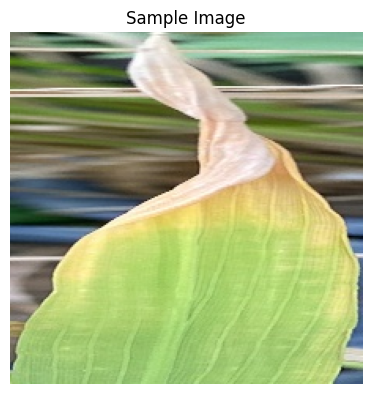

In [35]:
import matplotlib.pyplot as plt

# Show sample image
img_path = dataset_path + "/Nitrogen(N)/untitled-1.JPG"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct color display

# Show original and augmented images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Sample Image")
plt.axis("off")

plt.show()

In [36]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

In [37]:
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)


Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [38]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base

print(f"Total layers in base model: {len(base_model.layers)}")

Total layers in base model: 154


In [51]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(train_gen.class_indices), activation='softmax')
])

print(f"How many classes: {len(train_gen.class_indices)}")

How many classes: 3


In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 2,025,795 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model with early stopping
history = model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[early_stopping])

# Unfreeze last few layers for fine-tuning  
base_model.trainable = True
for layer in base_model.layers[:50]:  # Freeze first 100 layers
    layer.trainable = False 

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 69s 815ms/step - accuracy: 0.8082 - loss: 0.4756 - val_accuracy: 0.5550 - val_loss: 1.5816
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 802ms/step - accuracy: 0.9753 - loss: 0.0775 - val_accuracy: 0.6633 - val_loss: 1.1084
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 794ms/step - accuracy: 0.9837 - loss: 0.0423 - val_accuracy: 0.7533 - val_loss: 0.9247
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 786ms/step - accuracy: 0.9907 - loss: 0.0228 - val_accuracy: 0.7550 - val_loss: 0.9884
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 793ms/step - accuracy: 0.9932 - loss: 0.0271 - val_accuracy: 0.5750 - val_loss: 2.2222
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 792ms/step - accuracy: 0.9937 - loss: 0.0202 - val_accuracy: 0.7417 - val_loss: 1.2167


In [54]:
# Recompile model with lower learning rate for fine-tuning
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Continue training with fine-tuning
fine_tune_epochs = 20
history_fine = model.fit(train_gen, epochs=fine_tune_epochs, validation_data=val_gen, callbacks=[early_stopping])

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 69s 805ms/step - accuracy: 0.9882 - loss: 0.0384 - val_accuracy: 0.7667 - val_loss: 0.8221
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 785ms/step - accuracy: 0.9952 - loss: 0.0209 - val_accuracy: 0.7550 - val_loss: 0.8418
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 784ms/step - accuracy: 0.9967 - loss: 0.0203 - val_accuracy: 0.7800 - val_loss: 0.7766
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 786ms/step - accuracy: 0.9967 - loss: 0.0164 - val_accuracy: 0.7883 - val_loss: 0.7616
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 787ms/step - accuracy: 0.9945 - loss: 0.0159 - val_accuracy: 0.7950 - val_loss: 0.7370
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 782ms/step - accuracy: 0.9965 - loss: 0.0161 - val_accuracy: 0.8300 - val_loss: 0.5601
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 782ms/step - accuracy: 0.9938 - loss: 0.0207 - val_accuracy: 0.8517 - val_loss: 0.5274
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 779ms/step - accuracy: 0.9937 - loss: 0.0196 - val_accu

In [60]:
model.save('rice_deficiency_model.h5')

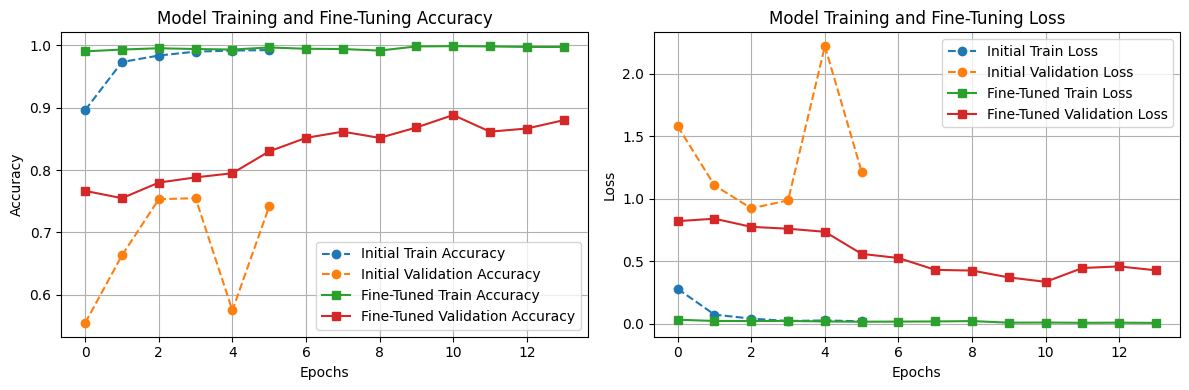

In [56]:
# Plot training history with labels and title
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(history.history['accuracy'], label='Initial Train Accuracy', linestyle='dashed', marker='o')
plt.plot(history.history['val_accuracy'], label='Initial Validation Accuracy', linestyle='dashed', marker='o')
plt.plot(history_fine.history['accuracy'], label='Fine-Tuned Train Accuracy', linestyle='solid', marker='s')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuned Validation Accuracy', linestyle='solid', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Training and Fine-Tuning Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.plot(history.history['loss'], label='Initial Train Loss', linestyle='dashed', marker='o')
plt.plot(history.history['val_loss'], label='Initial Validation Loss', linestyle='dashed', marker='o')
plt.plot(history_fine.history['loss'], label='Fine-Tuned Train Loss', linestyle='solid', marker='s')
plt.plot(history_fine.history['val_loss'], label='Fine-Tuned Validation Loss', linestyle='solid', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Training and Fine-Tuning Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

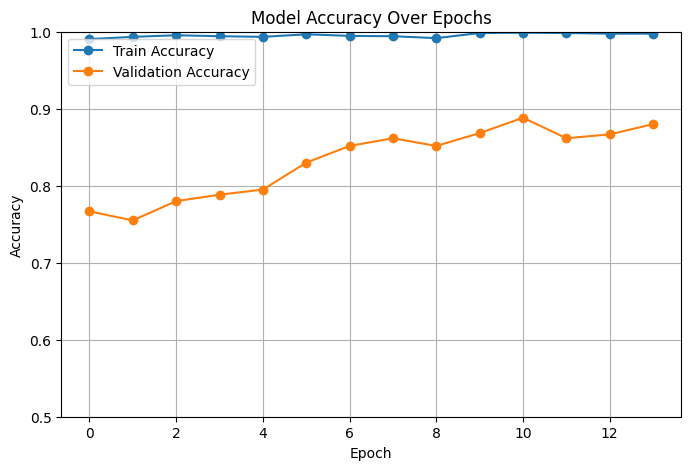

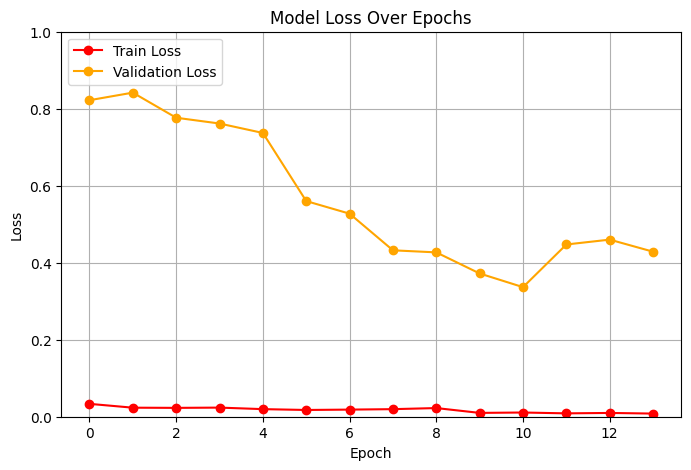

In [57]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_fine.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_fine.history['loss'], label='Train Loss', marker='o', color='red')
plt.plot(history_fine.history['val_loss'], label='Validation Loss', marker='o', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Classification testing
(can be run without running code above)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


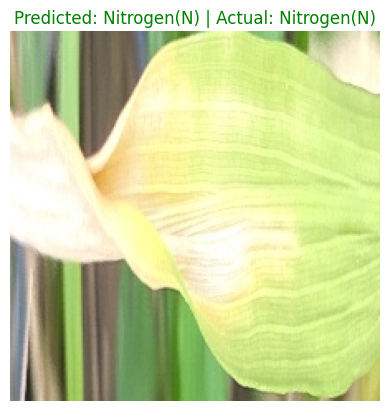

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


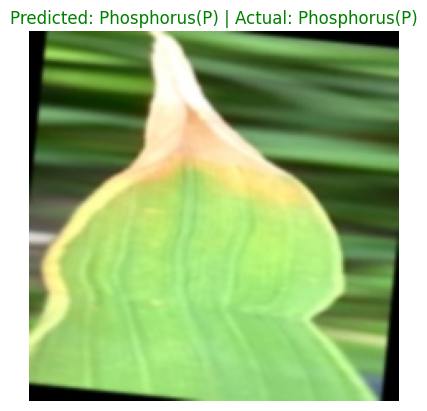

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


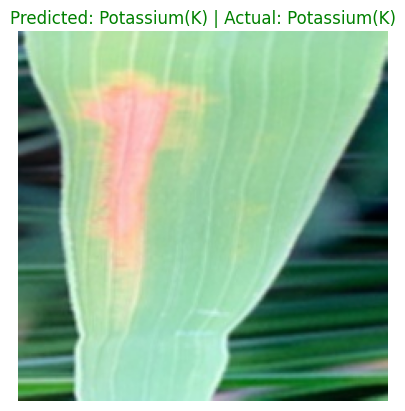

In [70]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Configuration ===
val_dir = "./dataset/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients"
img_size = (224, 224)  # Use the size your model expects
class_names = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)']
model_path = "rice_deficiency_model.h5"

# === Load the model ===
model = load_model(model_path)

# === Collect one random image per class ===
selected_images = []
true_class_labels = []

for class_name in class_names:
    class_path = os.path.join(val_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    if not image_files:
        continue
    random_file = random.choice(image_files)
    img_path = os.path.join(class_path, random_file)
    selected_images.append(img_path)
    true_class_labels.append(class_name)

# === Predict and visualize ===
for i, img_path in enumerate(selected_images):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_input)
    pred_class_idx = np.argmax(pred[0])
    pred_class_name = class_names[pred_class_idx]

    # Show image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {pred_class_name} | Actual: {true_class_labels[i]}",
              color='green' if pred_class_name == true_class_labels[i] else 'red')
    plt.axis("off")
    plt.show()


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Load model
model = load_model('rice_deficiency_model.h5')

# Define class labels
classes = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)']

# Image path (change this)
img_path = 'N.png'

# Preprocessing function
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    return img_tensor

# Predict
img = preprocess_image(img_path)
prediction = model.predict(img)

class_idx = np.argmax(prediction[0])
class_label = classes[class_idx]
confidence = float(prediction[0][class_idx])

print(f"Predicted Class: {class_label}")
print(f"Confidence: {confidence:.4f}")